In [1]:
%matplotlib inline

In [2]:
# I'm not telling you what to import this time - it's an exam! 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 30


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.formatter.use_mathtext"]=True


### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy:
Padma Venkatraman

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

### a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

In [5]:
def get_mean_std_counts(noise_stream):
    mean = np.mean(noise_stream)
    sigma = np.std(noise_stream)
    return mean, sigma, len(noise_stream[noise_stream>=3*sigma]) + len(noise_stream[noise_stream<=-3*sigma])

# generate time array for time series
signal_time = np.linspace(0.0001, 1, 2**13)

# generate white noise -- gaussian
white_noise = np.random.normal(size=len(signal_time))
muwn, stdwn, cwn = get_mean_std_counts(white_noise)

# brown noise -- integrate white noise
brown_noise = scipy.integrate.cumulative_simpson(white_noise, x = signal_time)
brown_noise = np.pad(brown_noise, (1, 0), 'constant', constant_values=(0))

mubn, stdbn, cbn = get_mean_std_counts(brown_noise)

# pink noise -- used deterministic function given in J Timmer and M Konig (1995)
# generate frequency array correpsonding to time array 
freq = np.fft.rfftfreq(n = len(signal_time), d = signal_time[1] - signal_time[0])*2*np.pi
freq = freq[freq>0]
power_law = 1/np.where(freq == 0, float('inf'), np.sqrt(freq))
pink_noise = np.array([power_law[i]*np.random.randn() * np.cos(freq[i]*signal_time - np.random.uniform(0, 2*np.pi)) for i in range(len(freq))])
pink_noise = np.sum(pink_noise, axis=0)
mupn, stdpn, cpn = get_mean_std_counts(pink_noise)


Note: Pink noise was generated using a modified version of Equation (1) in Timmer et al 1995:
\begin{equation*}
x(t) \sim \sqrt{S(w)}\cos(wt - \phi(w))
\end{equation*}

where phase is randomized using $\phi(w) \in [0, 2\pi]$. In the paper they use a deterministic amplitude, but I randomize this too. So the equation I use is actually:
\begin{equation*}
x(t) \sim \sqrt{S(w)}\mathcal{N(0,1)}\cos(wt - \phi(w))
\end{equation*}

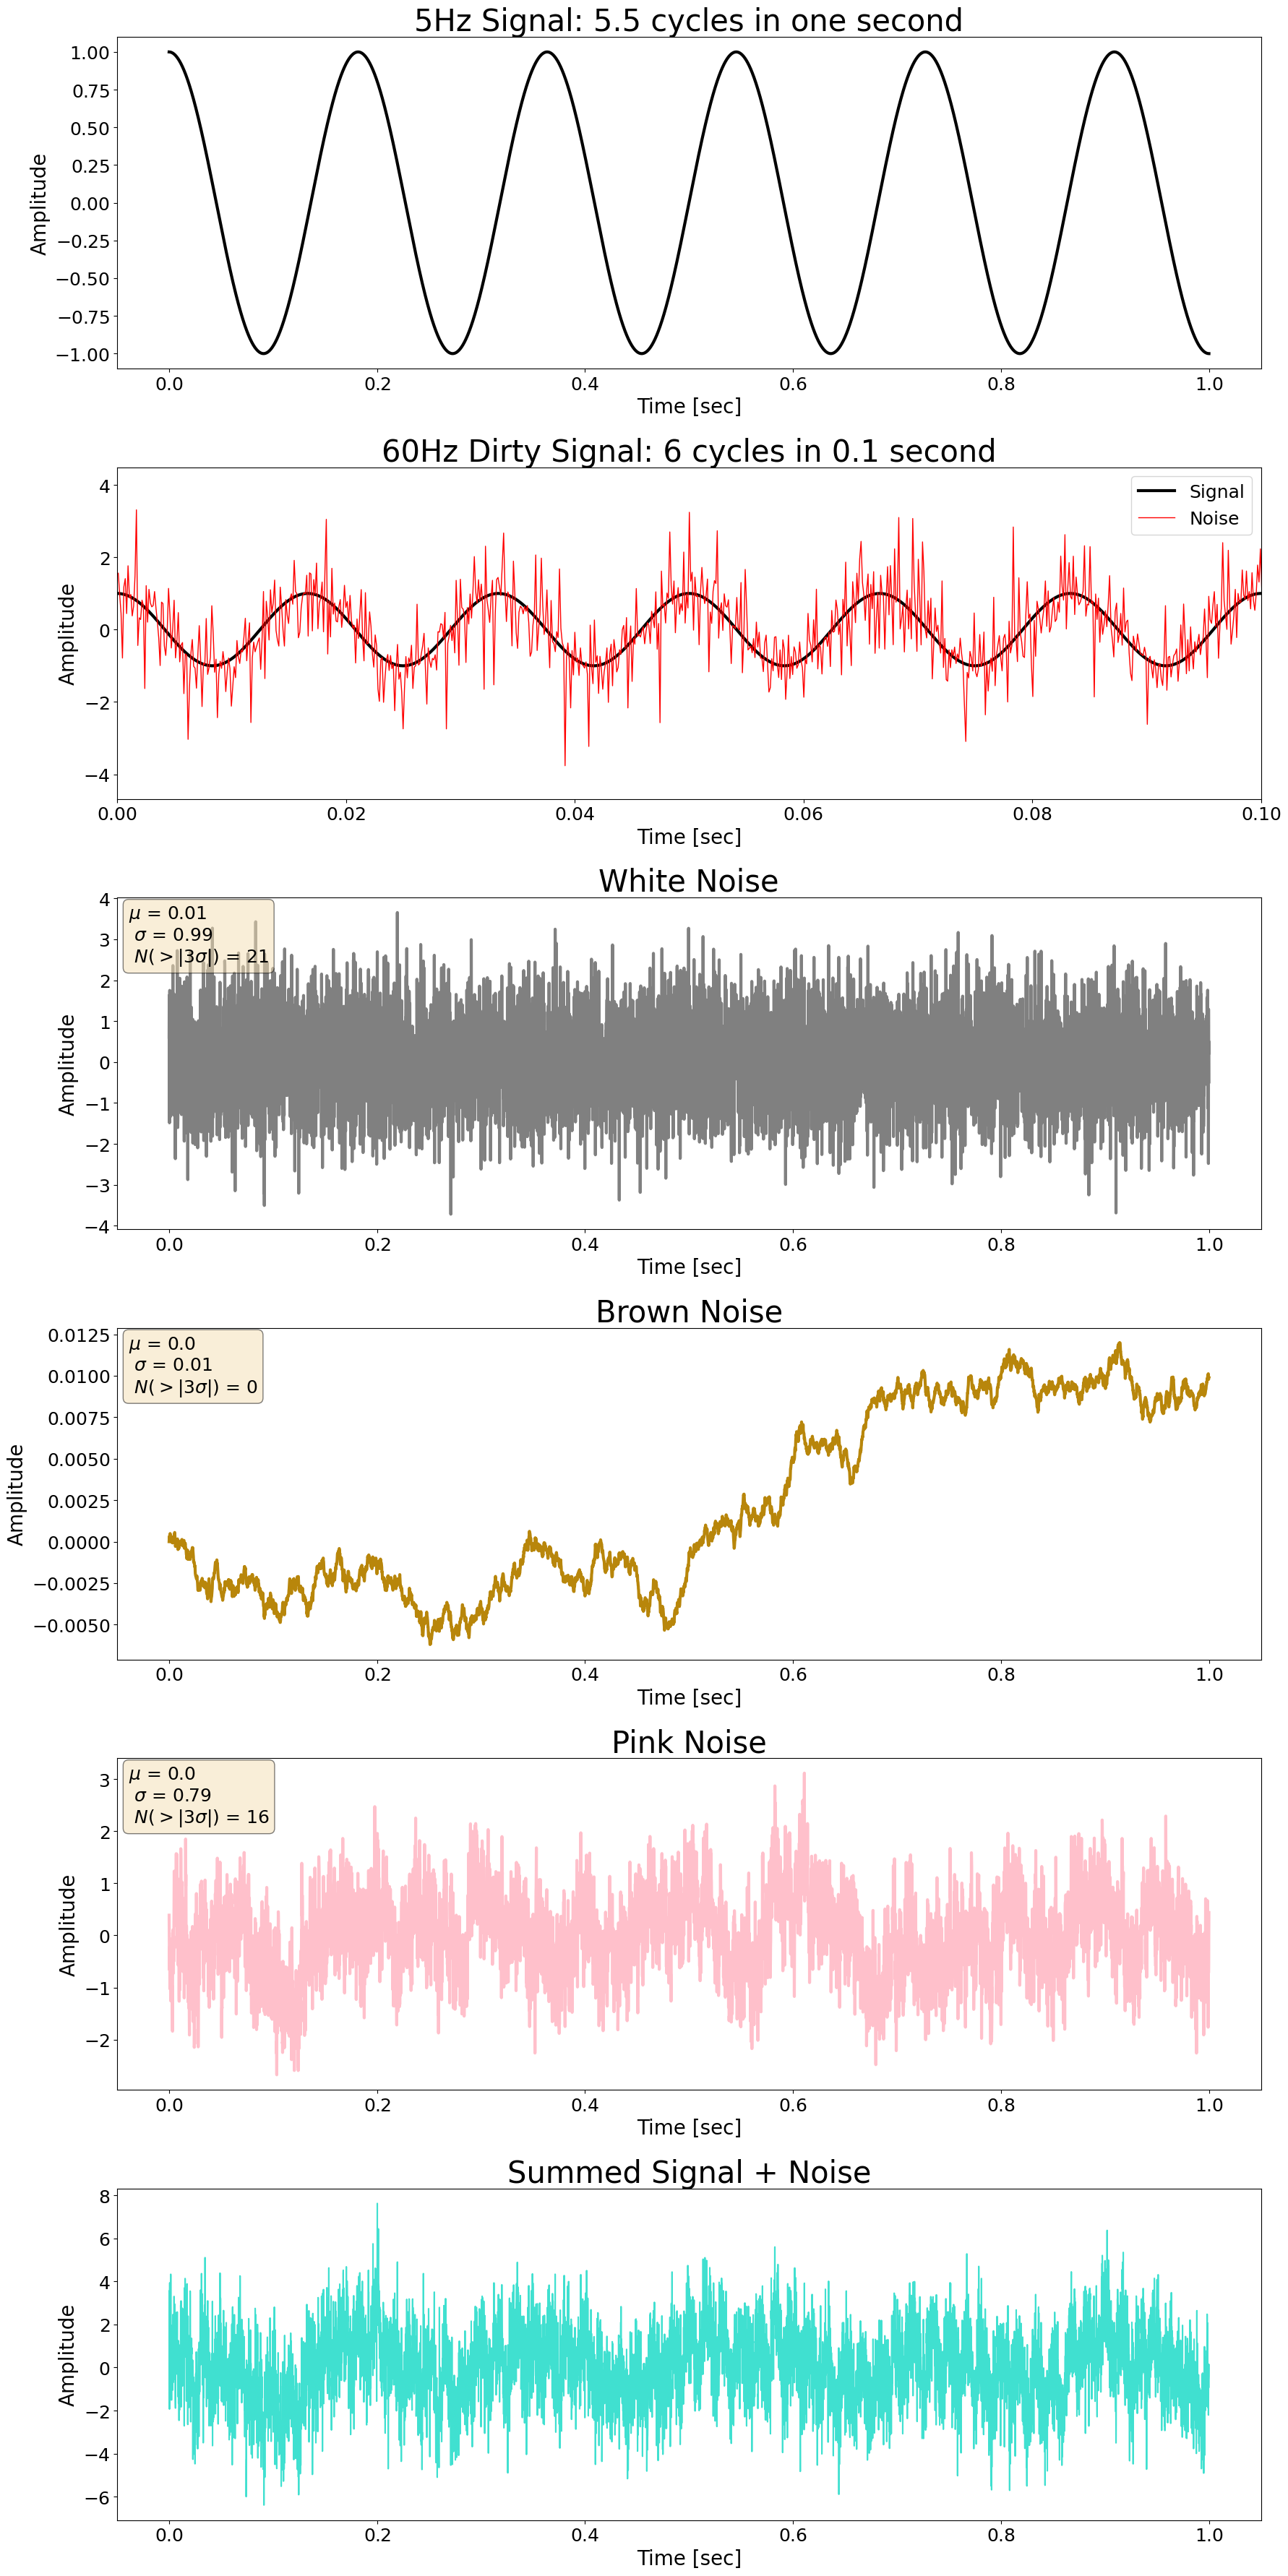

In [6]:
fig, ax = plt.subplots(6, 1, figsize=(18, 6*6))

# # I'm only showing the dirty signal for a 1/10th of the time, it gets too crowded and messy otherwise
# noise_time = np.arange(0, 0.1, 1/10000)[:1000]

signal_freq = 5.5  # Signal frequency
signal_freq_dirty = 60 # Dirty signal frequency

# real part of signal
clean_signal = np.cos(2 * np.pi * signal_freq * signal_time)
# The noise in dirty signal is usually 1kHz - 100kHz; there are random spikes; it is not sinusoidal
# The spikes can be the out-of-3-sigma values that creep in from using np.random.normal
# I've scaled the frequency of the noise as ~ 20 * signal 
noise = np.cos(2*np.pi*1200*signal_time)*np.random.normal(0,1, size=len(signal_time)) 
ax[0].plot(signal_time, clean_signal, color ='k', lw=3)
ax[0].set_title("5Hz Signal: 5.5 cycles in one second")

ax[1].plot(signal_time, np.cos(2*np.pi*60*signal_time), color ='k', lw=3, label='Signal')
dirty_signal = np.cos(2*np.pi*60*signal_time)+noise
ax[1].plot(signal_time, dirty_signal, color='r', lw=1, label='Noise')
ax[1].set_title("60Hz Dirty Signal: 6 cycles in 0.1 second")
ax[1].set_xlim(0, 0.1)

ax[1].legend()
ax[2].plot(signal_time, white_noise, color='gray', lw=3)
ax[2].set_title('White Noise')

def get_label_str(m, s, c):
    return f'$\mu$ = {np.round(m, 2)}\n $\sigma$ = {np.round(s,2)}\n $N(>|3\sigma|)$ = {np.round(c,2)}'

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax[2].text(0.01, 0.98, get_label_str(muwn, stdwn, cwn), transform=ax[2].transAxes, fontsize=SMALL_SIZE,
        verticalalignment='top', bbox=props)

# brown_noise = np.cusmum(white_noise) - np.mean(np.cumsum(white_noise))

ax[3].plot(signal_time, brown_noise, color='darkgoldenrod', lw=3)
# place a text box in upper left in axes coords
ax[3].text(0.01, 0.98, get_label_str(mubn, stdbn, cbn), transform=ax[3].transAxes, fontsize=SMALL_SIZE,
        verticalalignment='top', bbox=props)
ax[3].set_title('Brown Noise')
ax[4].plot(signal_time, pink_noise, color='pink', lw=3)
ax[4].set_title("Pink Noise")
ax[4].text(0.01, 0.98, get_label_str(mupn, stdpn, cpn), transform=ax[4].transAxes, fontsize=SMALL_SIZE,
        verticalalignment='top', bbox=props)

# there's a weird 1-indexing because brown noise is 1 less than the length of white noise
summed = clean_signal + dirty_signal + white_noise + brown_noise + pink_noise
ax[5].plot(signal_time, summed, color='turquoise')
ax[5].set_title("Summed Signal + Noise")
for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
# fig.supxlabel("Time [s]",size=50)
fig.tight_layout()


### b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

In [7]:
print(f"White noise: \nmean = {muwn}; \nstandard deviation = {stdwn}; \nNumber of time samples above or below 3 sigma = {cwn}\n\n")

print(f"Brown noise: \nmean = {mubn}; \nstandard deviation = {stdbn}; \nNumber of time samples above or below 3 sigma = {cbn}\n\n")

print(f"Pink noise: \nmean = {mupn}; \nstandard deviation = {stdpn}; \nNumber of time samples above or below 3 sigma = {cpn}")

White noise: 
mean = 0.005082169569074133; 
standard deviation = 0.991468316930894; 
Number of time samples above or below 3 sigma = 21


Brown noise: 
mean = 0.002274530501208047; 
standard deviation = 0.005491491628662929; 
Number of time samples above or below 3 sigma = 0


Pink noise: 
mean = 1.457167719820518e-15; 
standard deviation = 0.7923313589284164; 
Number of time samples above or below 3 sigma = 16


Reported above in the plot.

### c) Fourier Transform the time streams and plot the power spectral densities & 

### d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

In [8]:
def get_psd_from_time_stream(time, amplitude, with_hann = True):
    if with_hann:
        hann = np.hanning(len(amplitude))
    else:
        hann = 1

    freq = np.fft.rfftfreq(n = len(time), d = time[1] - time[0])
    freq_ = (freq>0)
    new_freq = freq[freq_]
    
    psd = (np.abs(np.fft.rfft(amplitude*hann))**2)[freq_]
    return new_freq, psd

In [9]:
from scipy.optimize import curve_fit
def power_law(data, beta, c0):
    return c0*(1/data)**beta

def get_fitted_vals(freqs, amps, beta  = 0):
    # x = np.log10(freqs)
    # y = np.log10(amps)
    popt, pcov = curve_fit(power_law, freqs, amps, p0 =[beta, 0])
    return popt, np.sqrt(np.diag(pcov))


##### I don't really understand the long tail going down to very small values in the plot below when I apply the hanning filter. The filter sorts out the leakage but introduces the long tail tending to values << 0. 

Text(0.5, 1.0, 'Without Hanning Filter')

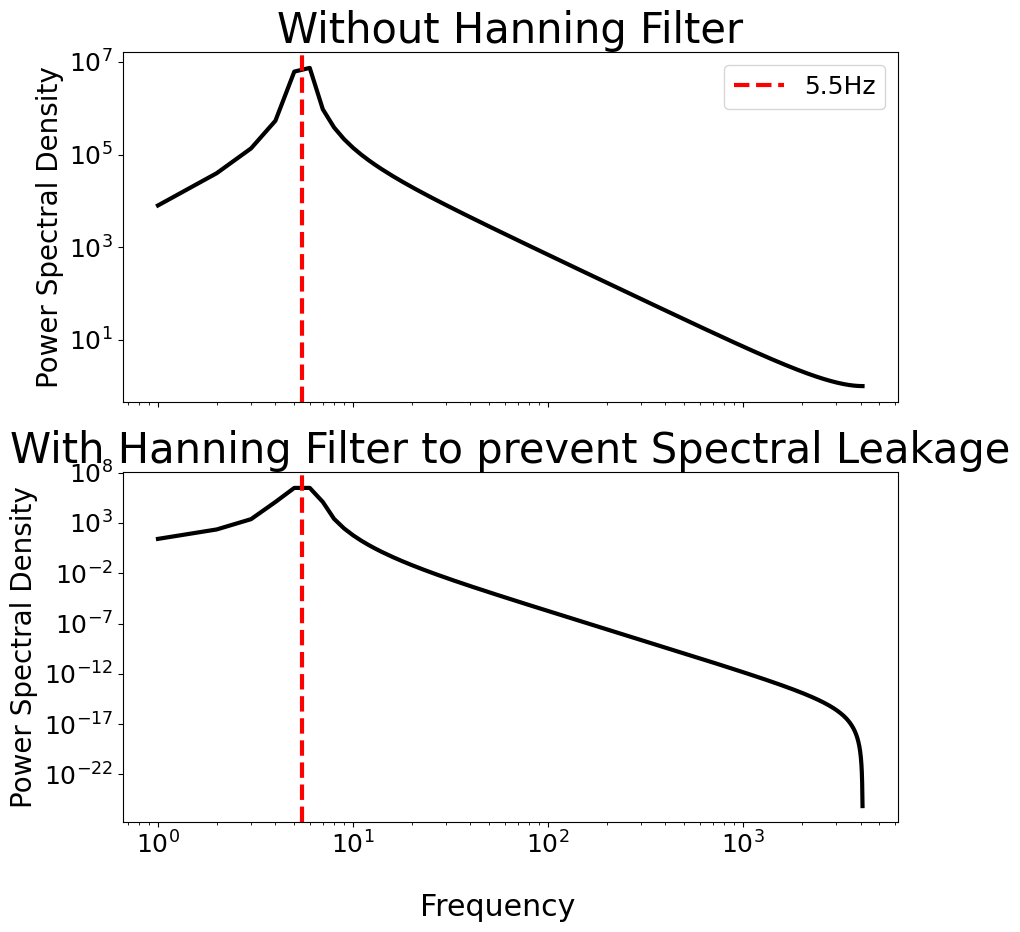

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
csfreq, cspsd = get_psd_from_time_stream(signal_time, clean_signal)
ax[1].loglog(csfreq, cspsd, color ='k', lw=3)
for a in ax:
    a.set_ylabel("Power Spectral Density")
fig.supxlabel("Frequency")
csfreq, cspsd = get_psd_from_time_stream(signal_time, clean_signal, with_hann=False)
ax[0].loglog(csfreq, cspsd, color ='k', lw=3)
ax[1].axvline(5.5, lw=3, color='r', ls='--', label='5.5Hz')
ax[0].axvline(5.5,lw=3, color='r', ls='--', label='5.5Hz')
ax[0].legend()

ax[1].set_title("With Hanning Filter to prevent Spectral Leakage")

ax[0].set_title("Without Hanning Filter")


In [11]:
# get all the power spectra
csfreq, cspsd =  get_psd_from_time_stream(signal_time, clean_signal)
dsfreq, dspsd =  get_psd_from_time_stream(signal_time, dirty_signal)
wfreq, wpsd = get_psd_from_time_stream(signal_time, white_noise)
bfreq, bpsd = get_psd_from_time_stream(signal_time, brown_noise)
pfreq, ppsd = get_psd_from_time_stream(signal_time, pink_noise)
sumfreq, sumpsd =  get_psd_from_time_stream(signal_time, summed)

##### Get all the best fit params and errors:
We model the noise as:
\begin{equation*}
P = c_0\frac{1}{f^\beta}
\end{equation*}

Where $c_0$ acts like the intercept in log space. The resulting fits are not highly accurate, but this could be due to sampling frequency or random variation. It could also be because I've modelled the data in linear space -- numerical instabilities, captures range of data best, penalizes extreme frequencies.

##### When I re-run the notebook several times, I do end up getting the correct fits 8/10 times, so I'm going to decide that this is a an error due to a random process and move on.

In [12]:
wparam, werr = get_fitted_vals(wfreq, wpsd, beta=0)
bparam, berr = get_fitted_vals(bfreq, bpsd, beta=2)
pparam, perr = get_fitted_vals(pfreq, ppsd, beta=1)

In [13]:
print(f"Best fit parameters for white noise: logarithmic power-law slope = {wparam[0]} with uncertainty = {werr[0]}.")

print(f"Best fit parameters for brown noise: logarithmic power-law slope = {bparam[0]} with uncertainty = {berr[0]}.")

print(f"Best fit parameters for pink noise: logarithmic power-law slope = {pparam[0]} with uncertainty = {perr[0]}.")


Best fit parameters for white noise: logarithmic power-law slope = -0.0023349910174643097 with uncertainty = 0.01572194694241447.
Best fit parameters for brown noise: logarithmic power-law slope = 2.1967058411882596 with uncertainty = 0.005454915811717174.
Best fit parameters for pink noise: logarithmic power-law slope = 0.6520543015352994 with uncertainty = 0.010073170446366282.


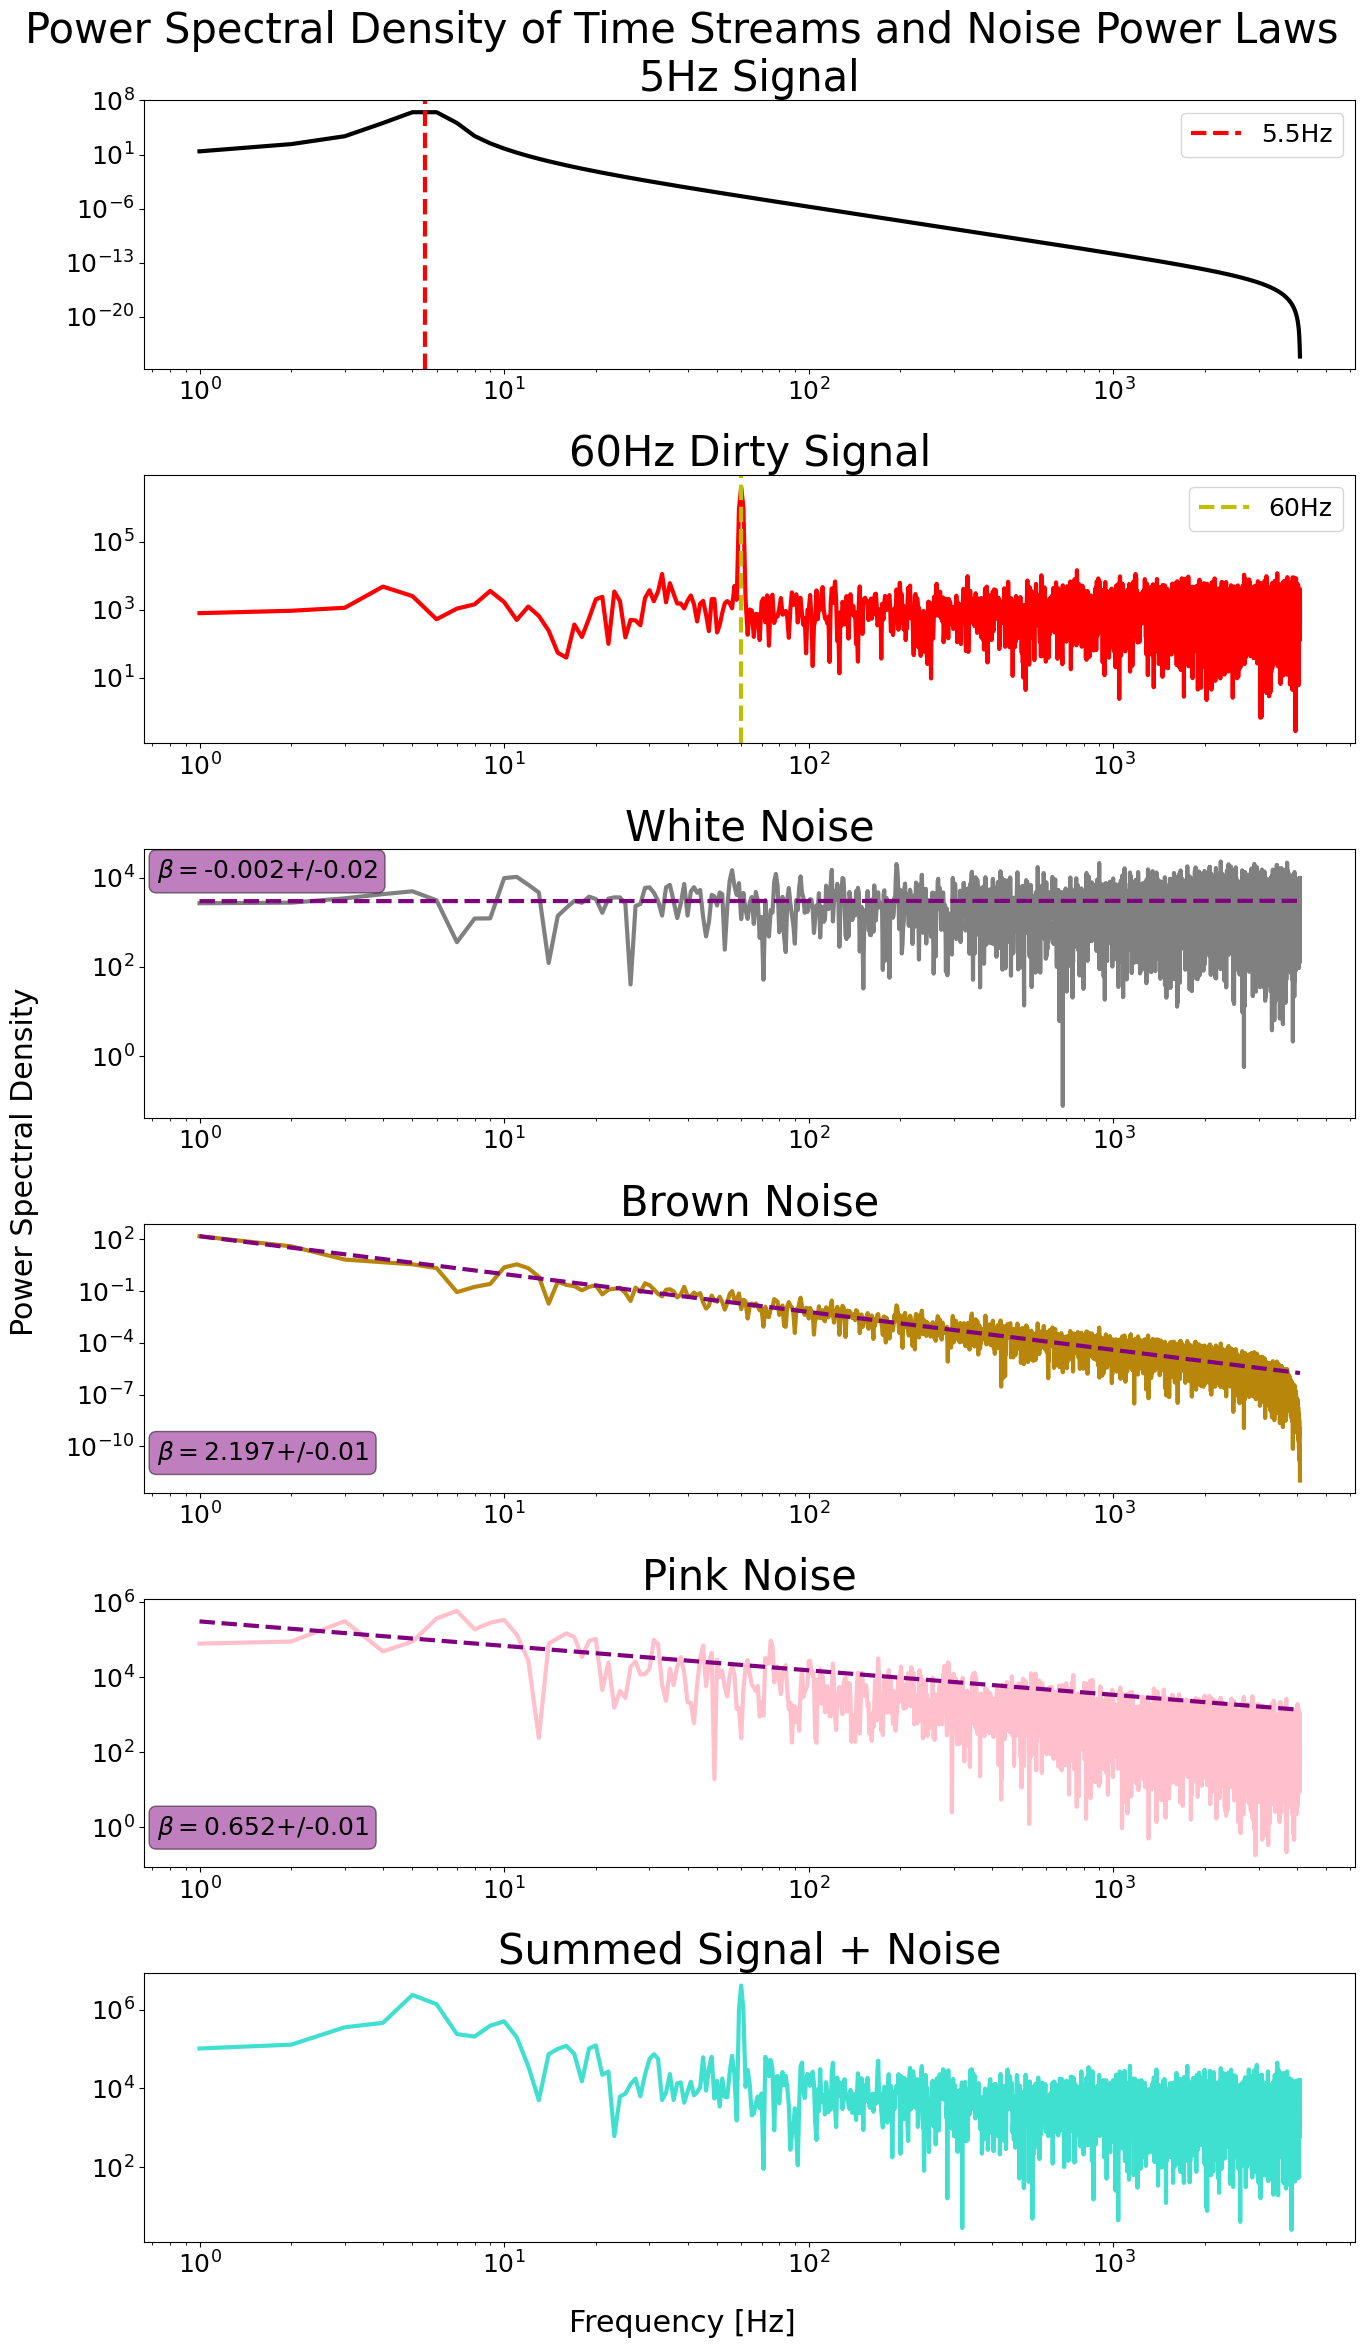

In [17]:

fig, ax = plt.subplots(6, 1, figsize=(14, 4*6), sharex=0)
ax[0].loglog(csfreq, cspsd, color ='k', lw=3)
ax[0].axvline(5.5,lw=3, color='r', ls='--', label='5.5Hz')
ax[0].legend()
ax[1].loglog(dsfreq, dspsd, color ='r', lw=3)
ax[1].axvline(60,lw=3, color='y', ls='--', label='60Hz')
ax[1].legend()
ax[2].loglog(wfreq, wpsd, color ='gray', lw=3)
ax[2].loglog(wfreq, wparam[1]*(1/wfreq)**wparam[0], ls='--', color='purple', lw=3)
props = dict(boxstyle='round', facecolor='purple', alpha=0.5)

ax[2].text(0.01, 0.97, '$\\beta = $' + f'{np.round(wparam[0],3)}+/-{np.round(werr[0],2)}', transform=ax[2].transAxes, fontsize=SMALL_SIZE,
        verticalalignment='top', bbox=props)

# ax[3].loglog(bfreq,bparam[0]*np.log10(bfreq) + bparam[1])
ax[3].loglog(bfreq, bpsd, color ='darkgoldenrod', lw=3)
ax[3].loglog(bfreq, bparam[1]*(1/bfreq)**bparam[0], ls='--', color='purple', lw=3)
ax[3].text(0.01, 0.2, '$\\beta = $' + f'{np.round(bparam[0],3)}+/-{np.round(berr[0],2)}', transform=ax[3].transAxes, fontsize=SMALL_SIZE,
        verticalalignment='top', bbox=props)


ax[4].loglog(pfreq, ppsd, color ='pink', lw=3)
ax[4].loglog(pfreq, pparam[1]*(1/pfreq)**pparam[0], ls='--', color='purple', lw=3)
ax[4].text(0.01, 0.2, '$\\beta = $' + f'{np.round(pparam[0],3)}+/-{np.round(perr[0],2)}', transform=ax[4].transAxes, fontsize=SMALL_SIZE,
        verticalalignment='top', bbox=props)



ax[5].loglog(sumfreq, sumpsd, color ='turquoise', lw=3)

ax[0].set_title("5Hz Signal")
ax[1].set_title("60Hz Dirty Signal")
ax[2].set_title('White Noise')
ax[3].set_title('Brown Noise')
ax[4].set_title("Pink Noise")
ax[5].set_title("Summed Signal + Noise")

fig.supylabel("Power Spectral Density")
fig.supxlabel("Frequency [Hz]")
fig.suptitle("Power Spectral Density of Time Streams and Noise Power Laws")
fig.tight_layout()

### e) To the total timestream: (3 + 3 + 2)
##### - apply a high-pass filter
##### - apply a low-pass filter
##### - plot the power spectral density

In [29]:

from scipy import signal

def butter_pass(cutoff, fs, type, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype=type, analog=False)
    return b, a

def butter_filter(data, cutoff, fs, type, order=5):
    b, a = butter_pass(cutoff, fs, type, order=order)
    y = signal.filtfilt(b, a, data)
    return y


In [30]:
low_pass = butter_filter(summed,50,len(summed), 'low')
high_pass = butter_filter(summed,50,len(summed), 'high')

In [31]:
lpf, low_pass_psd = get_psd_from_time_stream(signal_time, low_pass, with_hann=True)
hpf, high_pass_psd = get_psd_from_time_stream(signal_time, high_pass, with_hann=True)

##### In the cell below, I just chose the same cutoff for high and low passes to demonstrate how they operate on the full signal but the cutoff should probably be lower for the low pass and higher for the high pass.

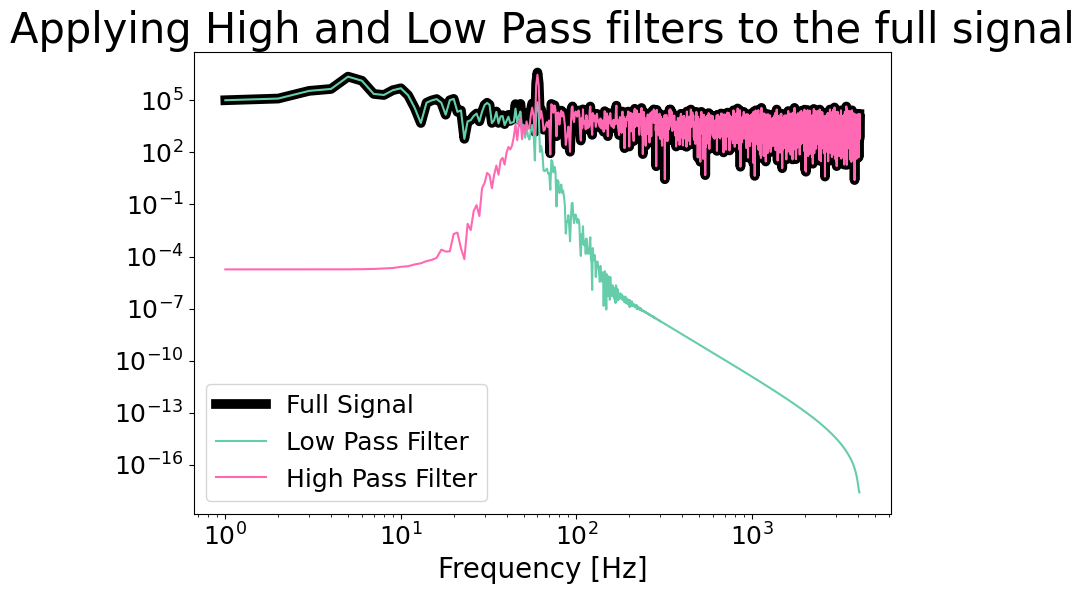

In [32]:
plt.figure(figsize=(9, 6))
plt.loglog(sumfreq, sumpsd, lw=7, color='k', label='Full Signal')
plt.loglog(lpf, low_pass_psd, color='mediumaquamarine', label='Low Pass Filter')
plt.loglog(hpf, high_pass_psd, color='hotpink', label='High Pass Filter')
plt.title("Applying High and Low Pass filters to the full signal")
plt.xlabel("Frequency [Hz]")
plt.legend();

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [33]:
from astropy.io import fits
spt_file = 'data/midterm/SPT0538-50_SPT_220GHz.fits'
alma_file = 'data/midterm/SPT0538-50_ALMA_870um.fits'

(np.float64(-0.5), np.float64(299.5), np.float64(-0.5), np.float64(299.5))

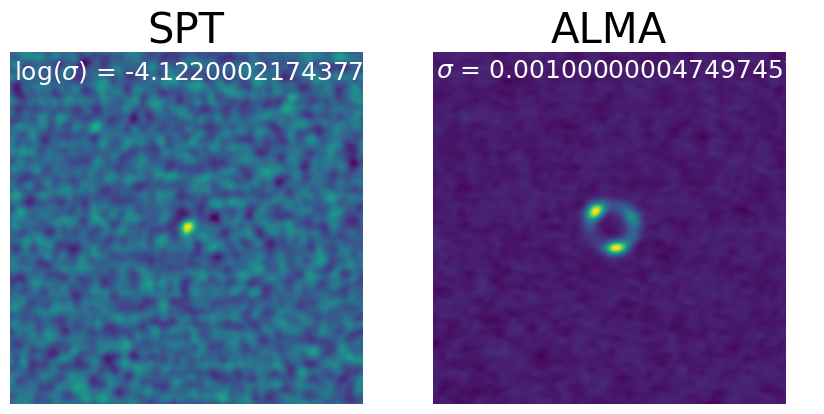

In [34]:
def get_noise(data, index = 30):
    # Here, I get the noise from a corner of the image   
    if data.shape[0] <=index:
        raise("You're not indexing correctly! Full image or larger than image indexing applied.")
    return np.std(data[:index, :index])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
spt = fits.open(spt_file)
spt_data = spt[0].data
ax[0].imshow(spt_data, origin='lower')
spt_std = get_noise(spt_data)
ax[0].text(0.01, 0.98, f'$\log(\sigma)$ = {np.round(np.log10(spt_std),3)}', transform=ax[0].transAxes, fontsize=SMALL_SIZE,
    verticalalignment='top', color='white')
ax[0].set_title('SPT')
ax[0].axis('off')
alma = fits.open(alma_file)
alma_data = alma[0].data[0][0]
ax[1].imshow(alma_data, origin='lower')
alma_std = get_noise(alma_data)
ax[1].text(0.01, 0.98, f'$\sigma$ = {np.round(alma_std,3)}', transform=ax[1].transAxes, fontsize=SMALL_SIZE,
    verticalalignment='top', color='white')
ax[1].set_title("ALMA")
ax[1].axis('off')



In [35]:
def get_max_snr(data):
    return np.max(data)/get_noise(data)

print(f"Max Signal to Noise for SPT map = {get_max_snr(spt_data)}")
print(f"Max Signal to Noise for ALMA map = {get_max_snr(alma_data)}")

Max Signal to Noise for SPT map = 9.029254913330078
Max Signal to Noise for ALMA map = 49.27830123901367


In [36]:
import trilogy
import skimage.io
import numpy as np
import io

# # Load the image
# # Convert the image to a NumPy array
# image_array = np.array(image)
imagesRGB = {"R": ['data/midterm/DESJ053816.9-503050.8_i.fits'], \
             "G": ['data/midterm/DESJ053816.9-503050.8_r.fits'], \
             "B": ['data/midterm/DESJ053816.9-503050.8_g.fits']}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
trilogy.Trilogy(infile = None, samplesize = 20000, stampsize = 20000, maxstampsize = 20000, \
                deletetests = 1, deletefilters = 1, testfirst = 0, showwith = "PIL", \
                mode = 'RGB', imagesorder = 'RGB', imagesRGB = imagesRGB, noiselums = noiselums, images = None, \
                outname = 'multiple_band_image', satpercent = 0.0009, noiselum = 0.5, noisesig = 50, \
                noisesig0 = 10, correctbias = 0, colorsatfac = 1, combine = 'sum', show = False).run()

From input file None :
From input parameters:
samplesize = 20000
stampsize = 20000
maxstampsize = 20000
deletetests = 1
deletefilters = 1
testfirst = 0
showwith = PIL
mode = RGB
imagesRGB = {'R': ['data/midterm/DESJ053816.9-503050.8_i.fits'], 'G': ['data/midterm/DESJ053816.9-503050.8_r.fits'], 'B': ['data/midterm/DESJ053816.9-503050.8_g.fits']}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
outname = multiple_band_image
satpercent = 0.0009
noiselum = 0.5
noisesig = 50
noisesig0 = 10
correctbias = 0
colorsatfac = 1
combine = sum
show = False
invert = False
Default:
indir =  (default)
outdir =  (default)
thumbnail = None (default)
sampledx = 0 (default)
sampledy = 0 (default)
showstamps = 0 (default)
scaling = None (default)
legend = 0 (default)
noise = None (default)
saturate = None (default)
bscale = 1 (default)
bzero = 0 (default)
Loading image data.
If multiple filters per channel, adding data.
B
data/midterm/DESJ053816.9-503050.8_g.fits[0] (1140, 1113) g
B = g

G
data/midterm/DESJ053816

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this for

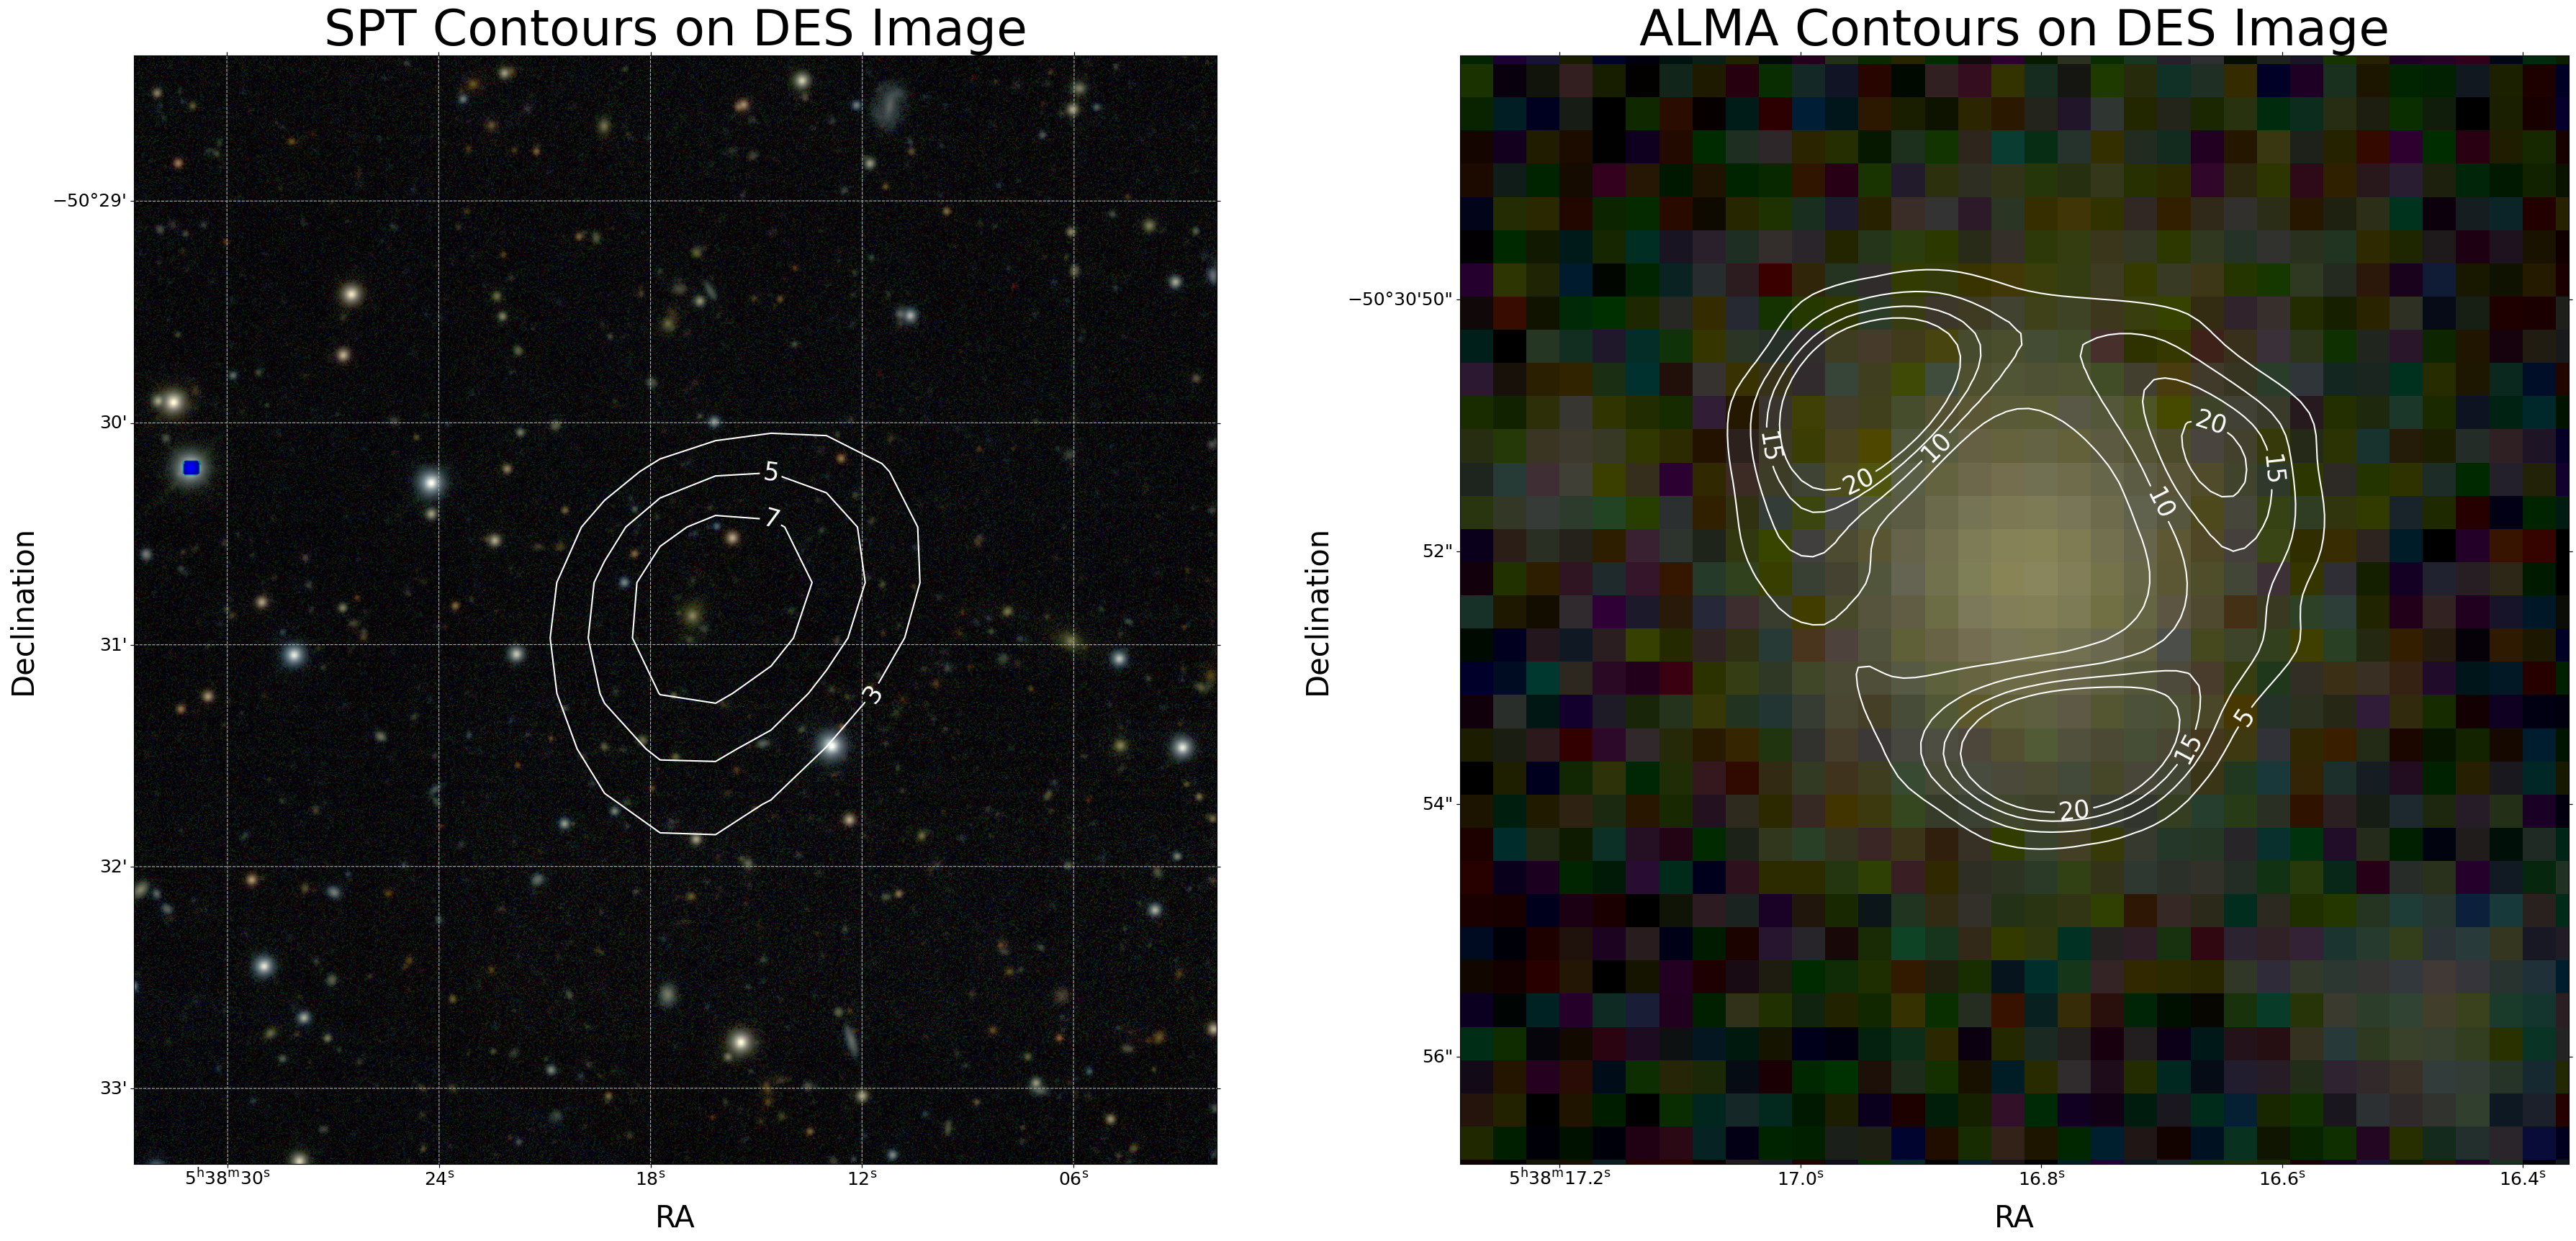

In [43]:
import skimage.io
from skimage.transform import resize
from PIL import Image
from astropy.wcs import WCS
fig = plt.figure(figsize=(22*2, 10*2))
# Load the image
des_g = fits.open('data/midterm/DESJ053816.9-503050.8_i.fits')[0]
image = Image.open("multiple_band_image.png")

# get the projection from a des image
des_wcs = WCS(des_g)
ax = fig.add_subplot(1,2,1, projection=des_wcs)

# Convert the image to a NumPy array
# image_resized = resize(
#     image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True
# )
# sptstd = np.std(spt_data)
im = ax.imshow(image)
c1 = ax.contour(spt[0].data, transform=ax.get_transform(WCS(spt[0].header)),levels=[3*spt_std, 5*spt_std, 7*spt_std],colors='white')

fmt = {}
strs = ['3', '5', '7']
for l, s in zip(c1.levels, strs):
    fmt[l] = s

# Label every other level using strings
ax.clabel(c1, c1.levels, inline=True, fmt=fmt, fontsize=25)
ax.grid(ls='--')
ax2 = fig.add_subplot(1,2,2, projection=des_wcs)
im2 = ax2.imshow(image)
c2 = ax2.contour(alma[0].data[0][0], transform=ax2.get_transform(WCS(alma[0].header).celestial),levels=[5*alma_std, 10*alma_std, 15*alma_std, 20*alma_std],colors='white')
ax2.set_xlim(1113*0.5, 0.53*1113)
ax2.set_ylim(1113*0.49, 0.52*1113)

fmt = {}
strs = ['5', '10', '15', '20']
for l, s in zip(c2.levels, strs):
    fmt[l] = s

# Label every other level using strings
ax2.clabel(c2, c2.levels, inline=True, fmt=fmt, fontsize=25)
ax.set_xlabel("RA", fontsize=BIGGER_SIZE)
ax.set_title("SPT Contours on DES Image", fontsize=50)
ax2.set_xlabel("RA", fontsize=BIGGER_SIZE)
ax.set_ylabel("Declination", fontsize=BIGGER_SIZE)
ax2.set_ylabel("Declination", fontsize=BIGGER_SIZE)
ax2.set_title("ALMA Contours on DES Image", fontsize=50)


fig.tight_layout()

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [38]:
ra_deg = (18 + 36/60 + 56/3600)*15
dec_deg = 38 + 47/60 + 1/3600
print(f'RA in degrees: {ra_deg}, Declination in degrees: {dec_deg}')
from astropy.coordinates import SkyCoord
c=SkyCoord(ra_deg, dec_deg, unit='deg')
l=c.galactic.l.degree
b=c.galactic.b.degree

print(f"Galactic Coordinates: l = {l}; b = {b}")


RA in degrees: 279.23333333333335, Declination in degrees: 38.78361111111111
Galactic Coordinates: l = 67.44773817064588; b = 19.238253586512474


In [39]:
# urbana 
obs_lat = 40.112
obs_long = -88.221

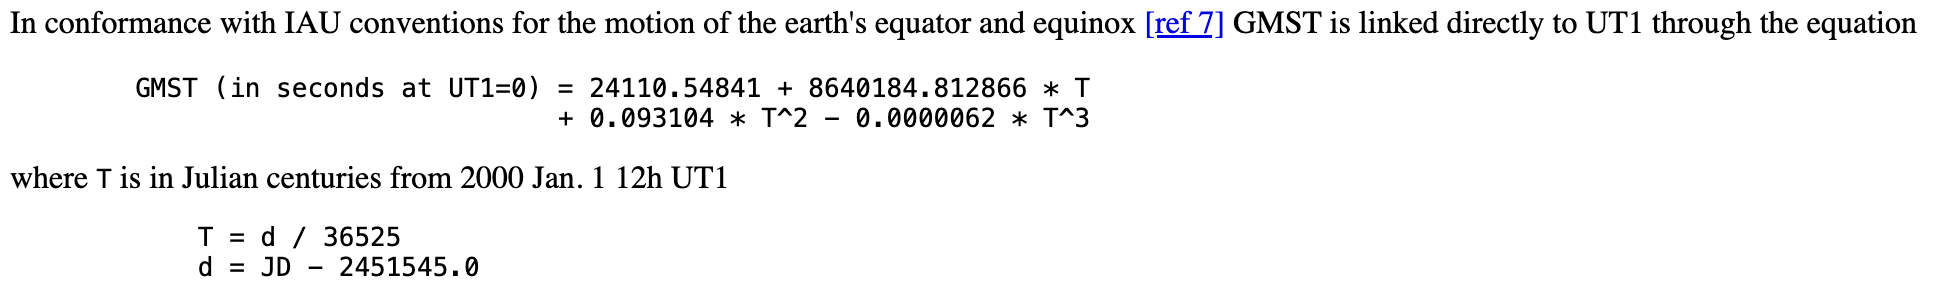

Here, d is the number of days since 2001 - 01 - 01.

In [40]:
import datetime
# number of day of daylight savings change
# on march 10, clocks move back; 7pm is 6pm
# on november 3, clocks move forward; 7pm is 8pm
subtract = (datetime.date(2024, 3, 10) - datetime.date(2024, 1, 1)).days
add = (datetime.date(2024, 11, 3) - datetime.date(2024, 1, 1)).days

In [41]:
jan12024 = datetime.datetime(2024, 1, 1)

def get_t(d):
    return ((jan12024 - datetime.datetime(2000, 1, 1)).days + d)/36525

def gmst(t):
    inhr = (24110.54841 + 8640184.812866 * t + 0.093104 * t**2 - 0.0000062 * t**3)/3600 # seconds to hours
    return inhr % (24) # this is similar to normalization. you want this to be meaningful on a 24-hr timescale

def rise_set_time(ra, dec, day):
    ra_in_hr = ra/15
    dec_in_hr = dec/15
    dec_in_rad = dec * np.pi/180

    obs_lat = 40.112*np.pi/180 # in radian
    obs_long = -88.221/15 # in hours
    hour_angle = 1/15 * np.arccos(-np.tan(obs_lat)*np.tan(dec_in_rad))*180/np.pi # in hour
    lst_rise = (24 + ra_in_hr - hour_angle) % 24
    lst_set = (ra_in_hr + hour_angle) % 24
    gst_rise = (lst_rise - obs_long) % 24
    gst_set = (lst_set - obs_long) % 24
    t = get_t(day)
    gmst_time = gmst(t)
    final_rise_time = (gst_rise - gmst_time - 5) % 24
    final_set_time = (gst_set - gmst_time - 5) % 24
    final_rise_time[subtract+1:add] +=1
    final_set_time[subtract+1:add] +=1
    return final_rise_time, final_set_time


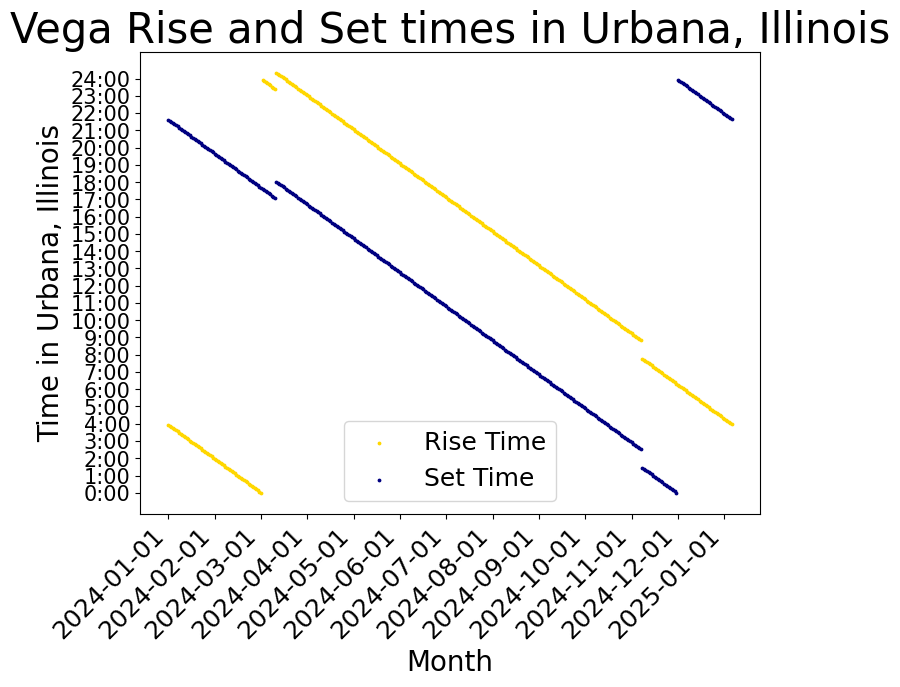

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
days = np.arange(366)
rise_times, set_times = rise_set_time(ra_deg, dec_deg, days)
ax.scatter(days, rise_times, label='Rise Time', s=3, color='gold')
ax.scatter(days, set_times, label='Set Time', s=3, color='navy')
index = pd.date_range(start = "2023-12-31", end = "2025-01-01", freq = "ME")
index = [pd.to_datetime(date, format='%Y-%m').date() for date in index]
ax.set_xticks(np.arange(0, 366, step=30), labels=np.arange(0, 366, step=30), rotation=45, ha='right')

index = pd.date_range(start = "2023-12-31", end = "2025-01-01", freq = "ME")
index = index + pd.Timedelta(days=1)
ax.set_xticklabels(labels=index.date)
ax.set_yticks(np.arange(0, 25, step=1))
ax.set_yticklabels([f'{i}:00' for i in np.arange(0, 25, step=1)], size=15)
ax.set_xlabel('Month')
ax.set_ylabel('Time in Urbana, Illinois')

ax.set_title('Vega Rise and Set times in Urbana, Illinois')

plt.legend()

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!